
--- Summary for policy: UTILITY ---
  Goal (1, 4) EDR: 0.1608
  Goal (3, 5) EDR: 0.2297
  Total Throughput: 0.3904
  Jain's Fairness Index: 0.9698
  Aged-Out Ratio (last 1000 steps): 0.4267
  Action Decision Ratio (last 1000 steps): 0.6400


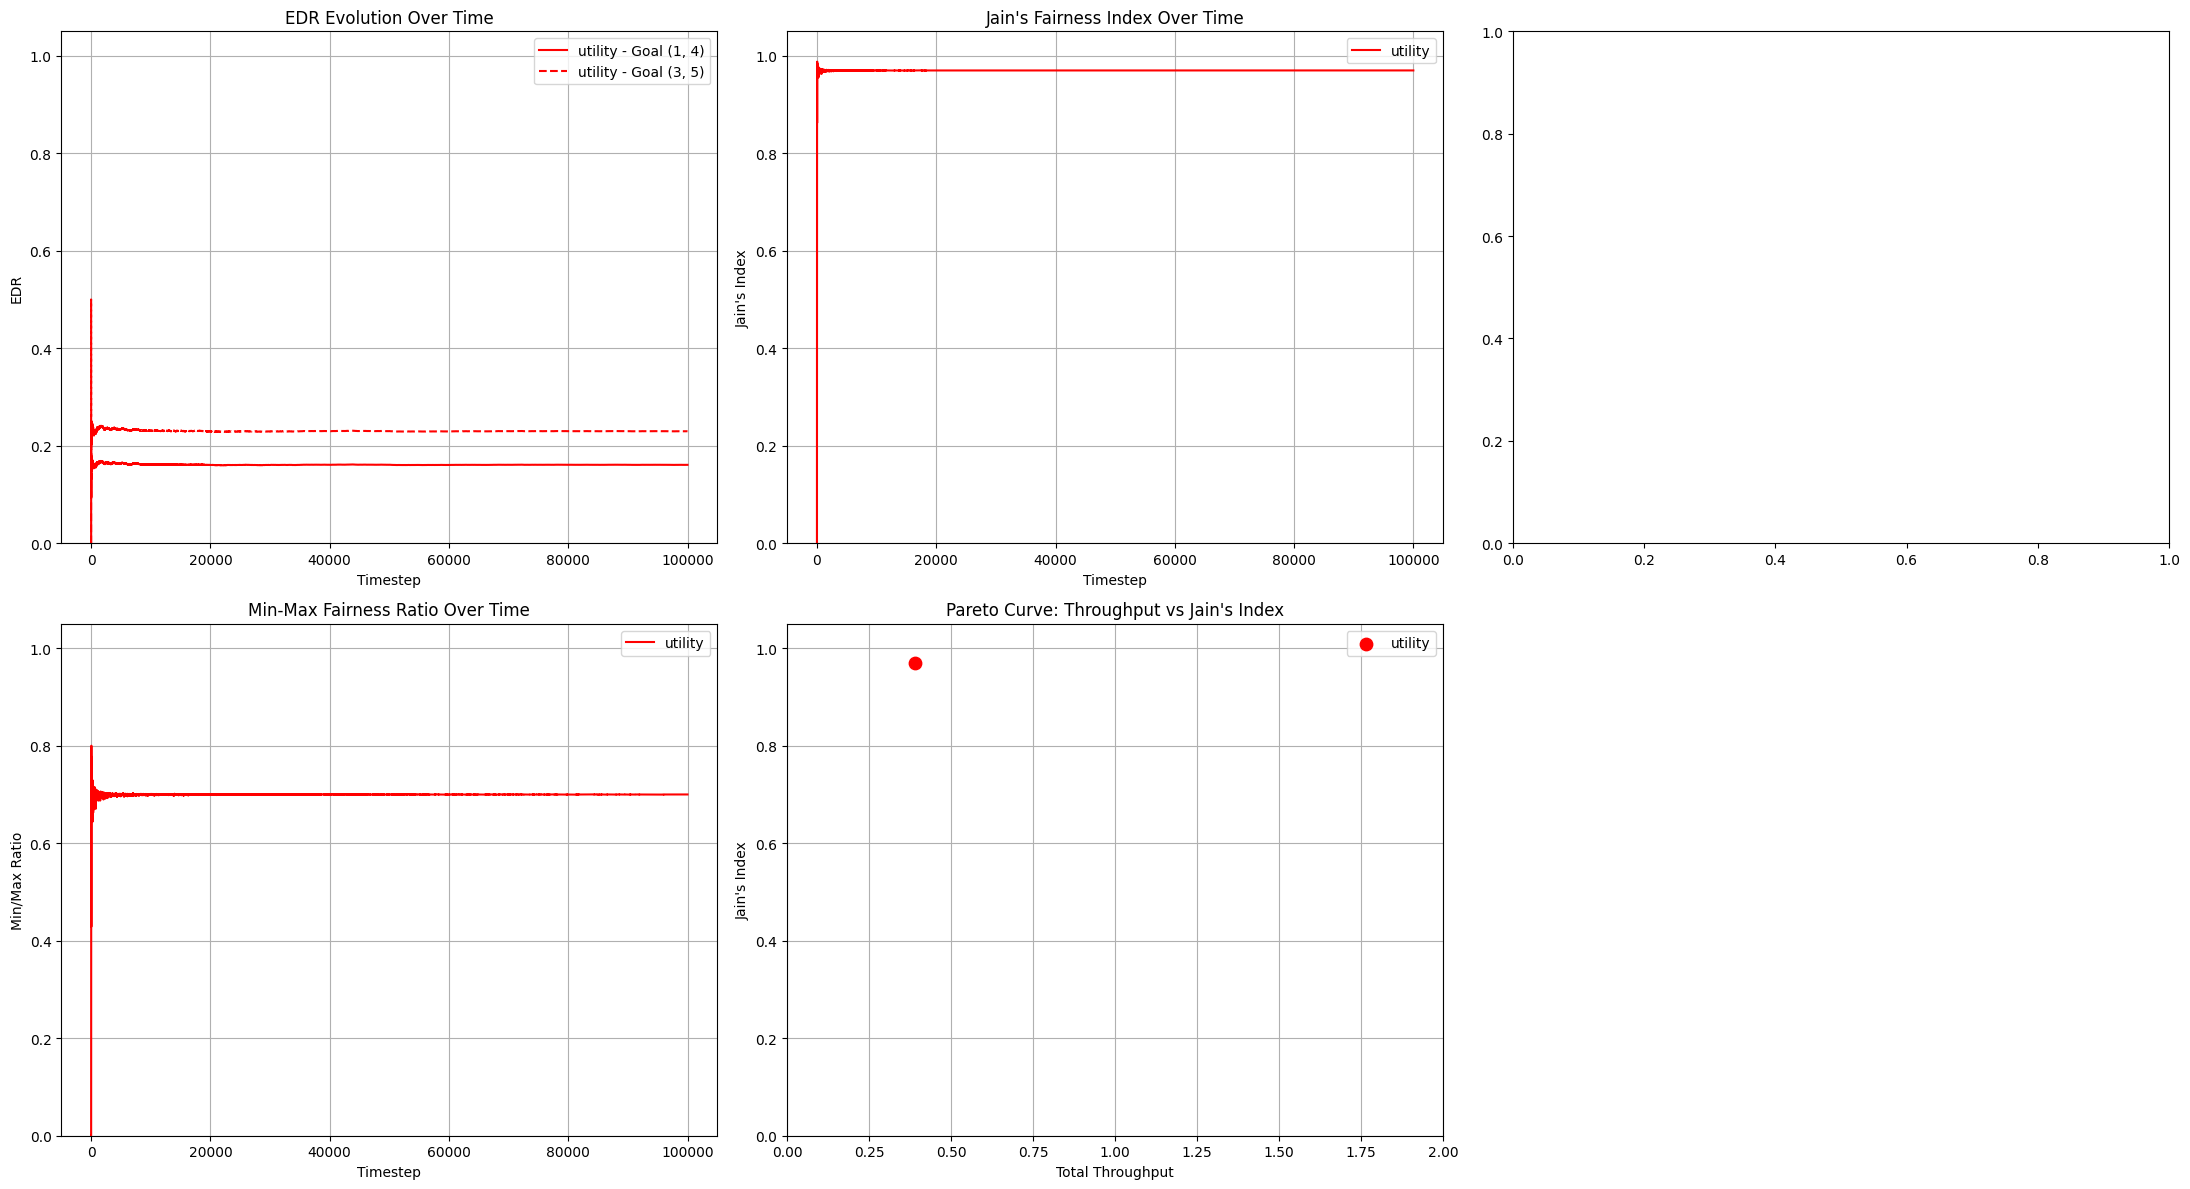


--- Summary for policy: LOWEST_EDR ---
  Goal (1, 4) EDR: 0.1895
  Goal (3, 5) EDR: 0.1896
  Total Throughput: 0.3791
  Jain's Fairness Index: 1.0000
  Aged-Out Ratio (last 1000 steps): 0.4336
  Action Decision Ratio (last 1000 steps): 0.6610


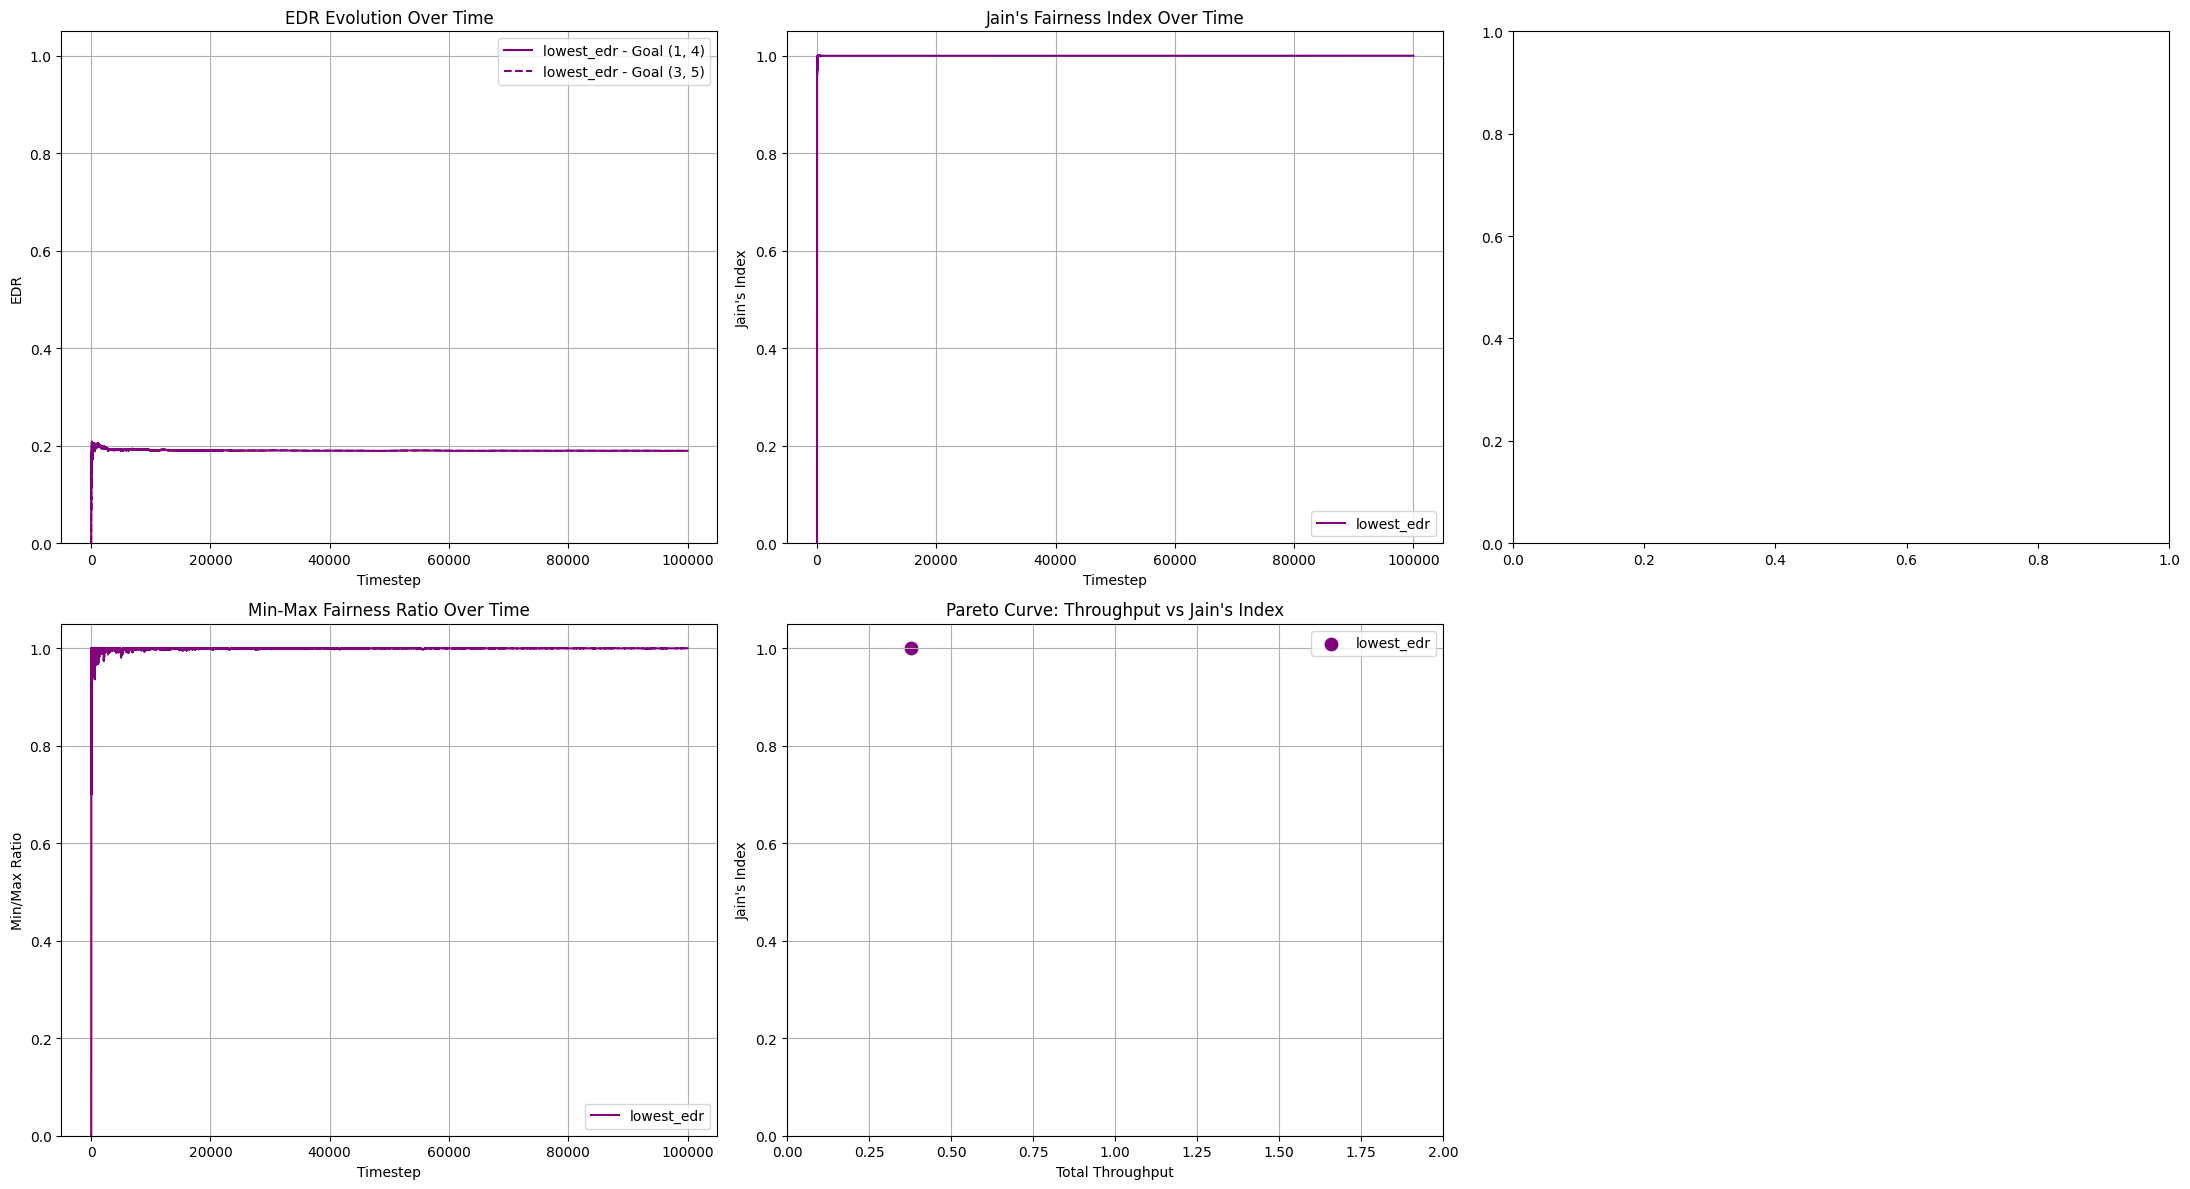

In [4]:
import random
import numpy as np
import matplotlib.pyplot as plt

from utility import (
    getPossibleActions,
    performAction,
    ageEntanglements,
    generateEntanglement,
    jains_index,
    min_max_fairness,
    rolling_average
)


    
def print_greedy_summary(results_dict, goal_edges):
    """
    Print summary statistics for greedy policy simulation results.
    Accepts the dictionary structure outputted by simulate_policy_multi_greedy().
    """
    for policy, res in results_dict.items():
        print(f"\n--- Summary for policy: {policy.upper()} ---")
        total_time = res['total_timesteps']
        goals_achieved = res['goals_achieved']
        final_edrs = {g: goals_achieved[g] / max(1, total_time) for g in goal_edges}
        
        # Print per-goal EDR
        for g in goal_edges:
            print(f"  Goal {g} EDR: {final_edrs[g]:.4f}")
        
        # Print totals
        throughput = sum(final_edrs.values())
        fairness = jains_index(final_edrs)
        print(f"  Total Throughput: {throughput:.4f}")
        print(f"  Jain's Fairness Index: {fairness:.4f}")
        print(f"  Aged-Out Ratio (last 1000 steps): {np.mean(res['aged'][-1000:]):.4f}")
        print(f"  Action Decision Ratio (last 1000 steps): {np.mean(res['actions'][-1000:]):.4f}")


def dict_to_state(state_dict):
    return [(edge, age) for edge, age in sorted(state_dict.items())]

def state_to_dict(state_list):
    return {edge: age for edge, age in state_list}

import random

def choose_action(policy_type, actions, goal_success_counts, total_timesteps, pSwap):
    if not actions:
        return ([], None)

    if policy_type == 'random':
        return random.choice(actions)

    if policy_type == 'spf':
        min_length = min(len(path) for path, _ in actions)
        shortest_actions = [action for action in actions if len(action[0]) == min_length]
        return random.choice(shortest_actions)

    if policy_type == 'lowest_edr':
        return min(actions, key=lambda x: goal_success_counts.get(x[1], 0) / max(1, total_timesteps))

    if policy_type == 'utility':
        def utility(action):
            path, goal = action
            if not goal or not path:
                return 0
            rate = pSwap ** (len(path) - 1)
            edr = goal_success_counts.get(goal, 0) / max(1, total_timesteps)
            return np.log(1+rate / max(1e-4, edr))
        return max(actions, key=utility)

    return ([], None)


def simulate_policy_multi_greedy(edges, goalEdges, pSwap, pGen, maxAge, policy_type, num_steps=10000):
    total_timesteps = 0
    goal_success_counts = {goal: 0 for goal in goalEdges}
    goal_attempt_counts = {goal: 0 for goal in goalEdges}
    edr_history = {goal: [] for goal in goalEdges}
    fairness_history = {'jains_index': [], 'min_max_ratio': [], 'cv': []}
    aged_out_history = []
    action_ratio_history = []

    current_state = {edge: -1 for edge in edges}

    for step in range(num_steps):
        state_list = dict_to_state(current_state)
        possible_actions = getPossibleActions(state_list, goalEdges)
        valid_actions = [a for a in possible_actions if a[0]]

        best_action = choose_action(policy_type, valid_actions, goal_success_counts, total_timesteps, pSwap)

        action_taken = best_action and best_action != ([], None)
        action_ratio_history.append(1.0 if valid_actions and action_taken else 0.0)

        if action_taken:
            consumed_edges, goal = best_action
            goal_attempt_counts[goal] += 1
            if random.random() < pSwap ** (len(consumed_edges) - 1):
                goal_success_counts[goal] += 1

        num_existing_before = sum(1 for _, age in state_list if age >= 0)
        state_list = performAction(best_action, state_list)
        state_list = ageEntanglements(state_list, maxAge)
        num_existing_after = sum(1 for _, age in state_list if age >= 0)
        num_aged_out = num_existing_before - num_existing_after

        state_list = generateEntanglement(state_list, pGen)
        current_state = state_to_dict(state_list)
        num_generated = sum(1 for _, age in state_list if age == 1)

        aged_out_ratio = num_aged_out / (num_aged_out + num_generated) if num_generated > 0 else 0.0
        aged_out_history.append(aged_out_ratio)

        total_timesteps += 1
        current_edrs = {goal: goal_success_counts[goal] / total_timesteps for goal in goalEdges}
        for goal in goalEdges:
            edr_history[goal].append(current_edrs[goal])

        jains = jains_index(current_edrs)
        minmax = min_max_fairness(current_edrs)
        cv = np.std(list(current_edrs.values())) / max(1e-6, np.mean(list(current_edrs.values())))
        fairness_history['jains_index'].append(jains)
        fairness_history['min_max_ratio'].append(minmax)
        fairness_history['cv'].append(cv)
    return edr_history, fairness_history, goal_success_counts, goal_attempt_counts, total_timesteps, aged_out_history, action_ratio_history

def plot_greedy_policy_results(results, goalEdges):
    print_greedy_summary(results, goal_edges)
    fig, axs = plt.subplots(2, 3, figsize=(22, 12))
    policy_colors = {'spf': 'blue', 'random': 'green', 'lowest_edr': 'purple', 'utility': 'red'}

    # --- EDR Evolution ---
    for policy, res in results.items():
        for i, goal in enumerate(goalEdges):
            linestyle = '-' if i == 0 else '--'
            axs[0][0].plot(
                res['edr_history'][goal],
                label=f'{policy} - Goal {goal}',
                color=policy_colors.get(policy),
                linestyle=linestyle
            )
    axs[0][0].set_title("EDR Evolution Over Time")
    axs[0][0].set_xlabel("Timestep")
    axs[0][0].set_ylabel("EDR")
    axs[0][0].set_ylim(0, 1.05)
    axs[0][0].legend()
    axs[0][0].grid(True)

    # --- Jain's Fairness ---
    for policy, res in results.items():
        axs[0][1].plot(
            res['fairness_history']['jains_index'],
            label=policy,
            color=policy_colors.get(policy)
        )
    axs[0][1].set_title("Jain's Fairness Index Over Time")
    axs[0][1].set_xlabel("Timestep")
    axs[0][1].set_ylabel("Jain's Index")
    axs[0][1].set_ylim(0, 1.05)
    axs[0][1].legend()
    axs[0][1].grid(True)

    # --- Min-Max Ratio ---
    for policy, res in results.items():
        axs[1][0].plot(
            res['fairness_history']['min_max_ratio'],
            label=policy,
            color=policy_colors.get(policy)
        )
    axs[1][0].set_title("Min-Max Fairness Ratio Over Time")
    axs[1][0].set_xlabel("Timestep")
    axs[1][0].set_ylabel("Min/Max Ratio")
    axs[1][0].set_ylim(0, 1.05)
    axs[1][0].legend()
    axs[1][0].grid(True)

    # --- Pareto Curve ---
    for policy, res in results.items():
        final_edrs = {g: res['goals_achieved'][g] / max(1, res['total_timesteps']) for g in goalEdges}
        throughput = sum(final_edrs.values())
        jain = jains_index(final_edrs)
        axs[1][1].scatter([throughput], [jain], label=policy, color=policy_colors.get(policy), s=80)

    axs[1][1].set_title("Pareto Curve: Throughput vs Jain's Index")
    axs[1][1].set_xlabel("Total Throughput")
    axs[1][1].set_ylabel("Jain's Index")
    axs[1][1].set_xlim(0, len(goalEdges))  # assuming max throughput = number of goals
    axs[1][1].set_ylim(0, 1.05)
    axs[1][1].grid(True)
    axs[1][1].legend()

    # Hide unused subplot (2,2)
    axs[1][2].axis('off')

    plt.tight_layout()
    plt.show()


def run_greedy_param_sweep(edges, goalEdges, param_name, param_values, fixed_params, num_steps=10000, policy='utility', plot=True):
    assert param_name in ['pGen', 'pSwap']
    all_results = {}

    for val in param_values:
        pGen = val if param_name == 'pGen' else fixed_params['pGen']
        pSwap = val if param_name == 'pSwap' else fixed_params['pSwap']
        print(f"Running {policy.upper()} with {param_name}={val}")

        edr_history, fairness_history, goals_achieved, goal_attempts, total_timesteps, aged, actions = simulate_policy_multi_greedy(
            edges, goalEdges, pSwap, pGen, fixed_params['maxAge'], policy, num_steps
        )
        final_edrs = {g: goals_achieved[g] / total_timesteps for g in goalEdges}
        all_results[val] = {
            "edrs": final_edrs,
            "jain": jains_index(final_edrs),
            "minmax": min_max_fairness(final_edrs),
            "throughput": sum(final_edrs.values()),
            "aged": np.mean(aged[-1000:]),
            "actions": np.mean(actions[-1000:])
        }

    if plot:
        plot_greedy_param_sweep(all_results, param_values, param_name, goalEdges)

    return all_results

def plot_greedy_param_sweep(results, param_vals, param_name, goalEdges):
    fig, axs = plt.subplots(2, 3, figsize=(22, 10)); axs = axs.flatten()
    for goal in goalEdges:
        axs[0].plot(param_vals, [results[v]['edrs'][goal] for v in param_vals], marker='o', label=f"Goal {goal}")
    axs[0].set_title("EDR per Goal"); axs[0].legend(); axs[0].grid()

    axs[1].plot(param_vals, [results[v]['jain'] for v in param_vals], color='purple', marker='o')
    axs[1].set_title("Jain's Index"); axs[1].grid()

    axs[2].plot(param_vals, [results[v]['minmax'] for v in param_vals], color='green', marker='o')
    axs[2].set_title("Min-Max Ratio"); axs[2].grid()

    axs[3].scatter([results[v]['throughput'] for v in param_vals],
               [results[v]['jain'] for v in param_vals],
               color='darkred')
    axs[3].set_title("Pareto Curve: Throughput vs Jain's Index")
    axs[3].set_xlabel("Total Throughput (Sum of EDRs)")
    axs[3].set_ylabel("Jain's Fairness Index")
    axs[3].grid(True)


    axs[4].plot(param_vals, [results[v]['aged'] for v in param_vals], color='orange', marker='o')
    axs[4].set_title("Aged-Out Ratio"); axs[4].grid()

    axs[5].plot(param_vals, [results[v]['actions'] for v in param_vals], color='teal', marker='o')
    axs[5].set_title("Action Decision Ratio"); axs[5].grid()

    plt.tight_layout()
    plt.show()
    
def plot_full_greedy_param_analysis(results, param_vals, param_name, goal_edges, policy_name="Greedy"):
    fig, axs = plt.subplots(2, 3, figsize=(36, 12))
    axs = axs.flatten()

    # --- EDR per Goal
    for goal in goal_edges:
        edrs = [results[v]['edrs'][goal] for v in param_vals]
        axs[0].plot(param_vals, edrs, marker='o', label=f"Goal {goal}")
    axs[0].set_title("Final EDR per Goal")
    axs[0].set_xlabel(param_name)
    axs[0].set_ylabel("EDR")
    axs[0].set_ylim(0, 1)
    axs[0].legend()
    axs[0].grid(True)

    # --- Jain's Index
    jains = [results[v]['jain'] for v in param_vals]
    axs[1].plot(param_vals, jains, color='purple', marker='o')
    axs[1].set_title("Jain's Fairness Index")
    axs[1].set_xlabel(param_name)
    axs[1].set_ylabel("Jain's Index")
    axs[1].set_ylim(0, 1.05)
    axs[1].grid(True)

    # --- Min-Max Fairness
    minmax = [results[v]['minmax'] for v in param_vals]
    axs[2].plot(param_vals, minmax, color='green', marker='o')
    axs[2].set_title("Min-Max Fairness")
    axs[2].set_xlabel(param_name)
    axs[2].set_ylabel("Min / Max EDR")
    axs[2].set_ylim(0, 1.05)
    axs[2].grid(True)

    # --- Pareto Curve
    throughputs = [results[v]['throughput'] for v in param_vals]
    axs[3].scatter(throughputs, jains, color='darkred', s=60)
    axs[3].plot(throughputs, jains, color='black', linestyle='--', alpha=0.6)
    axs[3].set_title("Pareto Curve: Throughput vs Jain's Index")
    axs[3].set_xlabel("Total Throughput")
    axs[3].set_ylabel("Jain's Index")
    axs[3].set_xlim(0, 1.05)
    axs[3].set_ylim(0, 1.05)
    axs[3].grid(True)

    # --- Aged Out
    aged_vals = [results[v]['aged'] for v in param_vals]
    axs[4].plot(param_vals, aged_vals, color='orange', marker='o')
    axs[4].set_title("Aged-Out Entanglement Ratio")
    axs[4].set_xlabel(param_name)
    axs[4].set_ylabel("Ratio")
    axs[4].set_ylim(0, 1.05)
    axs[4].grid(True)

    # --- Action Ratio
    action_vals = [results[v]['actions'] for v in param_vals]
    axs[5].plot(param_vals, action_vals, color='teal', marker='o')
    axs[5].set_title("Action Decision Ratio")
    axs[5].set_xlabel(param_name)
    axs[5].set_ylabel("Ratio")
    axs[5].set_ylim(0, 1.05)
    axs[5].grid(True)

    # Title
    plt.suptitle(
        f"{policy_name} Policy Sweep: {param_name} ∈ {param_vals}",
        fontsize=18, y=1.02
    )
    plt.tight_layout(rect=[0, 0.05, 1, 0.97])
    plt.show()
    print_greedy_summary(results, goal_edges)








# === Setup parameters ===
edges       = [(0,1), (1,3), (2,3), (3,4), (4,5)]
goal_edges  = [(0,5), (2,4)]
pSwap       = 0.6
pGen        = 0.6
maxAge      = 3

edges       = [(1,2), (2,3), (3,4), (4,5)]
goal_edges  = [(1,4), (3,5)]

pSwap       = 0.7
pGen        = 0.7
maxAge      = 2

num_steps = 100000
policy = 'utility'
seed = 30
random.seed(seed)
np.random.seed(seed)

# === Simulate single greedy run ===
edr_history, fairness_history, goals_achieved, goal_attempts, total_timesteps, aged, actions = simulate_policy_multi_greedy(
    edges, goal_edges, pSwap, pGen, maxAge, policy, num_steps
)

# === Wrap into the format expected by plot_greedy_policy_results ===
results = {
    policy: {
        "edr_history": edr_history,
        "fairness_history": fairness_history,
        "goals_achieved": goals_achieved,
        "goal_attempts": goal_attempts,
        "total_timesteps": total_timesteps,
        "aged": aged,
        "actions": actions
    }
}

plot_greedy_policy_results(results, goal_edges)

policy = 'lowest_edr'
edr_history, fairness_history, goals_achieved, goal_attempts, total_timesteps, aged, actions = simulate_policy_multi_greedy(
    edges, goal_edges, pSwap, pGen, maxAge, policy, num_steps
)


results = {
    policy: {
        "edr_history": edr_history,
        "fairness_history": fairness_history,
        "goals_achieved": goals_achieved,
        "goal_attempts": goal_attempts,
        "total_timesteps": total_timesteps,
        "aged": aged,
        "actions": actions
    }
}
plot_greedy_policy_results(results, goal_edges)




# param_values = [0.2* i for i in range(1,6)]  # [0.1, 0.2, ..., 1.0]
# # Example sweep: vary pGen
# sweep_results = run_greedy_param_sweep(
#     edges=edges,
#     goalEdges=goal_edges,
#     param_name='pGen',
#     param_values=param_values,
#     fixed_params={'pGen': pSwap, 'pSwap': pGen, 'maxAge': maxAge},
#     policy='utility',  # or 'utility', 'random', etc.
#     num_steps=100000,
#     plot=False
# )

# plot_full_greedy_param_analysis(
#     results=sweep_results,
#     param_vals=param_values,
#     param_name='pGen',
#     goal_edges=goal_edges,
#     policy_name="Random Greedy"
# )
